In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from matplotlib import pyplot
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb

In [2]:
train = pd.read_csv('data/training_variants')
trainingText = pd.read_csv('data/training_text', sep="\|\|", engine='python', header=None, names=["ID","Text"], skiprows=1)

test = pd.read_csv('data/test_variants')
testText = pd.read_csv('data/test_text', sep="\|\|", engine='python', header=None, names=["ID","Text"], skiprows=1)
pid = test['ID'].values

train = train.merge(trainingText, on='ID', how='left')
test = test.merge(testText, on='ID', how='left')
train["nbWords"] = train["Text"].apply(lambda x: len(str(x).split()) )

In [3]:
train.head()

,ID,Gene,Variation,Class,Text,nbWords
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5722
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5722
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202


In [18]:
globalDict = Counter([])
for article in train["Text"].values:
    words = str(article).split()
    currentDict = Counter(words)
    globalDict = globalDict + currentDict
    


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [24]:
len(globalDict)
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
#ps.stem(w)

In [29]:
all_words = []
for article in train["Text"][:1].values:
    word_tokens = word_tokenize(article)
    print('Not filtered %s' % len(word_tokens))
    word_tokens = [w.lower() for w in word_tokens if not w in stop_words]
    print('Filtered %s' % len(word_tokens))
    all_words = nltk.FreqDist(word_tokens)
    
print(all_words)
print('most commun %s', all_words.most_common(10))


Not filtered 7306
Filtered 5487
<FreqDist with 1501 samples and 5487 outcomes>
most commun %s [(',', 351), ('.', 325), ('(', 233), (')', 233), ('cyclin', 89), ('m', 89), ('cdk10', 77), ('fig', 63), ('we', 54), ('ets2', 53)]


In [110]:
stop_words = set(stopwords.words('english'))
def getTermsAsArray(sentences):
    tokens = nltk.word_tokenize(sentences)
    words = [w.lower() for w in tokens if not w.lower() in stop_words and  w.isalnum() ]

    return words

def getTerms(sentences):
    tokens = nltk.word_tokenize(sentences)
    words = " ".join([w.lower() for w in tokens if not w.lower()  in stop_words and  w.isalnum()])

    return words

getTerms("hh, hh3h. wo shi 2 4 A . fdffdf. A&&B removing whitespaces and The punctuations ")

'hh hh3h wo shi 2 4 fdffdf b removing whitespaces punctuations'

In [111]:
trainingText['PText'] = trainingText['Text'].apply(getTerms)

In [127]:
trainingText.columns
countVect = CountVectorizer()
wordCountPerDoc = countVect.fit_transform(trainingText['PText'])
wordCountPerDoc

tTransformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(wordCountPerDoc)
tfidf = tfidf.toarray()

tfidf.shape

(3321, 125627)

In [115]:
# x = trainingText['PText'][1].split(' ')
# x = sorted(x)
# # x[5200:5700]

# print(len(x))
# print(x[int(len(x)*0.8):])

In [87]:
countVect.get_feature_names()[3000:3010]

['hair',
 'hairpin',
 'hairs',
 'hakai',
 'half',
 'hall',
 'hallmark',
 'hallmarks',
 'hand',
 'hands']

In [128]:
x = countVect.get_feature_names()
"the" in x

False

In [28]:
wordCountPerDoc.toarray().shape
wordCountPerDoc


(31, 7866)

In [138]:
# (countVect.get_feature_names(), np.asarray(wordCountPerDoc.sum(axis=0)).ravel())

su = wordCountPerDoc.sum(axis=0).tolist()[0]

mostFrequentWords = [(word, su[idx]) for word, idx in countVect.vocabulary_.items()]

mostFrequentWords = sorted(mostFrequentWords, key=lambda x : -x[1])

print(mostFrequentWords[:50])

sutf = tfidf.sum(axis=0).tolist()

mostFrequentWordsTF = [(word, sutf[idx]) for word, idx in countVect.vocabulary_.items()]
mostFrequentWordsTF
mostFrequentWordsTF = sorted(mostFrequentWordsTF, key=lambda x : -x[1])

print(mostFrequentWordsTF[:50])

def magicFrequency(countVect, tfidf, wordCountPerDoc) : 
    su = wordCountPerDoc.sum(axis=0).tolist()[0]
    sutf = tfidf.sum(axis=0).tolist()
    
    mostFrequentWords = [(word, su[idx], sutf[idx]) for word, idx in countVect.vocabulary_.items()]
    mostFrequentWords = sorted(mostFrequentWords, key=lambda x : -x[1])
    mostFrequentWordsTF = sorted(mostFrequentWords, key=lambda x : -x[2])
    
    return (mostFrequentWords,mostFrequentWordsTF)

_, x = magicFrequency(countVect, tfidf, wordCountPerDoc)

x[:50]

[('mutations', 236727, 278.13197717049724),
 ('cells', 183587, 179.98823225068497),
 ('brca1', 53862, 171.32882933779436),
 ('variants', 65651, 136.32395733499496),
 ('fig', 100215, 130.84644224496046),
 ('et', 104558, 125.91538982307723),
 ('mutation', 102320, 121.00571142289769),
 ('cell', 113602, 114.3199881364006),
 ('figure', 97049, 109.04086350298445),
 ('cancer', 90589, 107.19948147838632),
 ('pten', 28524, 100.43479988330171),
 ('patients', 85595, 97.7626262566456),
 ('egfr', 46491, 93.73195875634964),
 ('activity', 75859, 89.86834103583409),
 ('protein', 79011, 85.98298384646772),
 ('kinase', 60257, 85.66607312213725),
 ('p53', 34296, 83.0608504884691),
 ('mutant', 67081, 79.25517082606873),
 ('mutants', 52966, 76.95650973176471),
 ('domain', 63014, 75.9609070247806),
 ('expression', 75308, 72.98765732425517),
 ('tumor', 61966, 72.84319413773588),
 ('using', 63489, 69.48294958657353),
 ('data', 59915, 68.79461793904291),
 ('also', 66345, 68.19023341816522),
 ('tumors', 52407, 

In [148]:
[x[0] for x in  mostFrequentWordsTF[:100]]


crapWords = ['mutations',
 'cells',
 'variants',
 'fig',
 'et',
 'mutation',
 'cell',
 'figure',
 'cancer',
 'patients',
 'activity',
 'protein',
 'kinase',
 'mutant',
 'mutants',
 'domain',
 'expression',
 'using',
 'data',
 'also',
 'tumors',
 'analysis',
 'gene',
 'table',
 'activation',
 'supplementary',
 'deleterious',
 'may',
 'variant',
 'genes',
 'results',
 'resistance',
 'functional',
 'identified',
 'used',
 'shown',
 'proteins',
 'clinical',
 'signaling',
 'missense',
 'human',
 'one',
 'found',
 'study',
 'assay',
 'function',
 'lines',
 '10',
 'assays',
 'levels',
 'neutral',
 'cases',
 'treatment',
 'observed',
 'receptor',
 'three',
 'structure',
 'pathway',
 'sequence',
 'studies',
 'different',
 'patient',
 'showed',
 'samples',
 'inhibitors',
 'reported',
 'associated',
 'however']

In [134]:
train['PText'] = trainingText['PText']

In [135]:
vectorizers = {}
transformers = {}
tfidfs = {}
wordCounts = {}
for c in train['Class'].unique():
    print(c)
    vectorizers[c] = CountVectorizer()
    wordCounts[c] = vectorizers[c].fit_transform(train[train['Class']==c]['PText'])
    
    transformers[c] = TfidfTransformer(smooth_idf=False)
    tfidfs[c] = transformers[c].fit_transform(wordCounts[c])
    tfidfs[c] = tfidfs[c].toarray()

1
2
3
4
5
6
7
8
9


In [169]:
mostPopularWords = {}

for c in train['Class'].unique():
    _, xx = magicFrequency(vectorizers[c], tfidfs[c],wordCounts[c])
    mostPopularWords[c] = [x[0] for x in xx]
    
    

In [191]:
def frequentWordsByText(text) :
    cleanText = getTerms(text)
    countVect = CountVectorizer()
    wordCountPerDoc = countVect.fit_transform([cleanText])
    
    mostFrequentWords = [(word, wordCountPerDoc[0,idx]) for word, idx in countVect.vocabulary_.items()]

    mostFrequentWords = sorted(mostFrequentWords, key=lambda x : -x[1])

    return mostFrequentWords

frequentWordsByText(train['PText'][5])


[('mutations', 150),
 ('cbl', 121),
 ('binding', 63),
 ('cancer', 62),
 ('stability', 40),
 ('effects', 33),
 ('fig', 32),
 ('activity', 30),
 ('protein', 30),
 ('table', 27),
 ('state', 26),
 ('cells', 26),
 ('states', 25),
 ('proteins', 22),
 ('egfr', 22),
 ('energy', 21),
 ('damaging', 21),
 ('methods', 20),
 ('changes', 19),
 ('random', 18),
 ('ubiquitination', 18),
 ('cell', 18),
 ('mutant', 18),
 ('mutation', 17),
 ('structures', 16),
 ('figure', 16),
 ('mutants', 16),
 ('activation', 16),
 ('found', 15),
 ('ncbl', 14),
 ('experimental', 14),
 ('using', 14),
 ('compared', 14),
 ('active', 14),
 ('e2', 14),
 ('densitometry', 14),
 ('experimentally', 13),
 ('data', 13),
 ('affinity', 13),
 ('driver', 13),
 ('e3', 13),
 ('different', 13),
 ('four', 12),
 ('computational', 12),
 ('according', 12),
 ('one', 11),
 ('hela', 11),
 ('10', 11),
 ('models', 11),
 ('a549', 11),
 ('free', 11),
 ('cycle', 11),
 ('destabilizing', 11),
 ('recurrent', 10),
 ('substrate', 10),
 ('observed', 10),
 

In [188]:
nboverlap = 100
currentTextID = 10

xx = frequentWordsByText(train['PText'][currentTextID])

xxx = [x[0] for x in xx]

m = -1
mi = -1 
for c in range(1,10):
    n = len(list(set(xxx[:nboverlap]) & set(mostPopularWords[c][:nboverlap])))
    if n > m:
        m = n
        mi = c
    print(c, n)

print(train['Class'][currentTextID], mi)

(1, 1248)
1248
1 31
2 27
3 27
4 31
5 28
6 30
7 29
8 26
9 28
4 1


In [195]:
train['fw'] = train['PText'].apply(lambda x : [wordTuple[0] for wordTuple in frequentWordsByText(x)])


In [197]:
train['fw'].head(5)

0    [cyclin, cdk10, fig, ets2, cells, expression, ...
1    [mutations, lung, cell, egfr, mutation, cells,...
2    [mutations, lung, cell, egfr, mutation, cells,...
3    [cbl, mutations, cases, aupd, upn, figure, mut...
4    [mutations, cbl, binding, cancer, stability, e...
Name: fw, dtype: object

In [342]:
nboverlap = 250

def overlapRange(fw, c, overlapSize):
    n = len(list(set(fw[:overlapSize]) & set(mostPopularWords[c][:overlapSize])))
    return float(n)/overlapSize
    

for i in range(1, 10):
    columnName = 'overlap' + str(nboverlap) + 'C'+str(i)
    train[columnName] = train['fw'].apply(lambda x: overlapRange(x, i, nboverlap))
    print(columnName)


overlap250C1
overlap250C2
overlap250C3
overlap250C4
overlap250C5
overlap250C6
overlap250C7
overlap250C8
overlap250C9


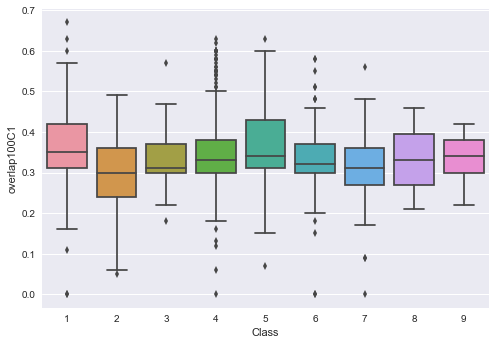

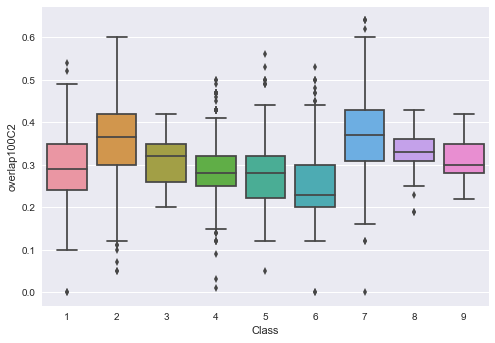

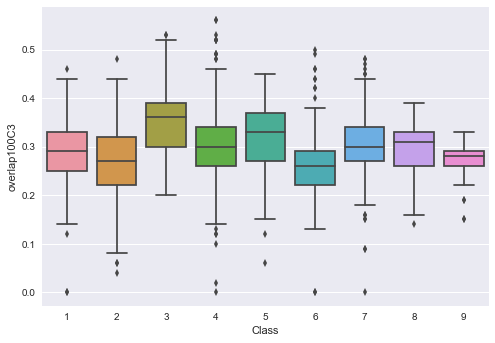

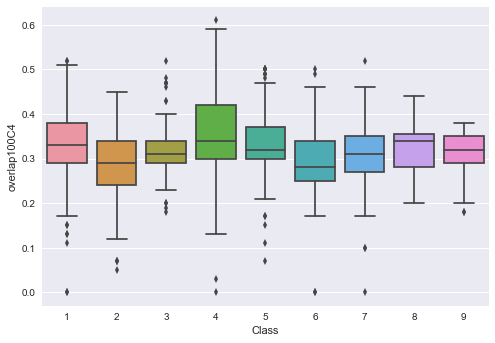

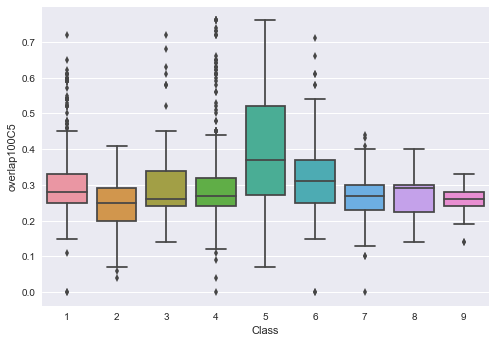

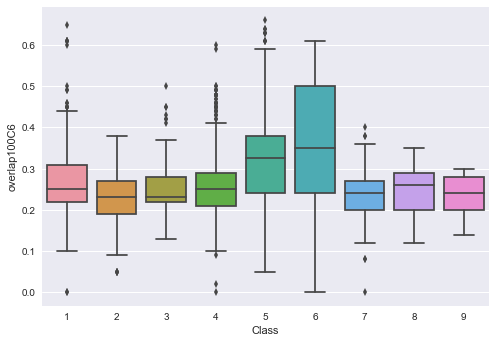

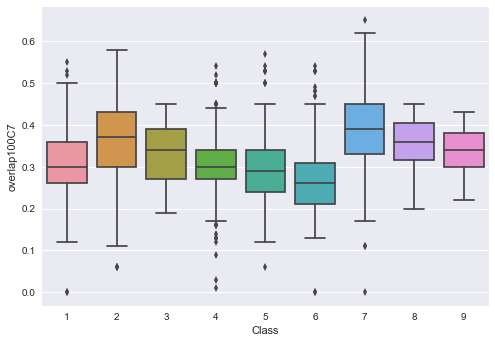

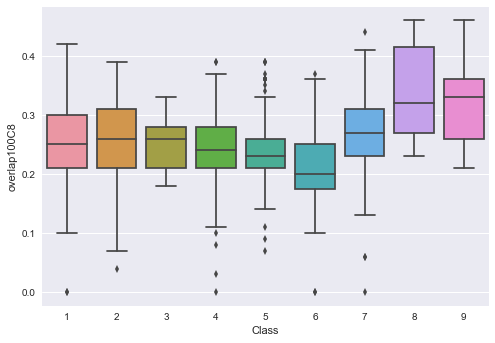

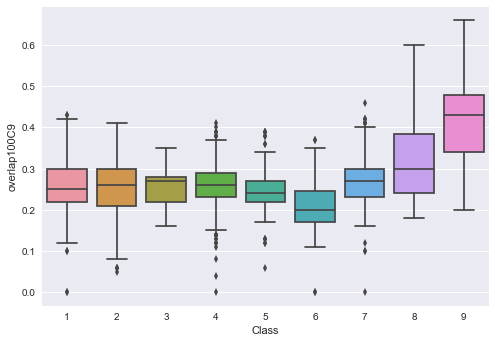

In [251]:
plt.ion()
sns.boxplot('Class', 'overlap100C1', data=train)
plt.show()
sns.boxplot('Class', 'overlap100C2', data=train)
plt.show()
sns.boxplot('Class', 'overlap100C3', data=train)
plt.show()
sns.boxplot('Class', 'overlap100C4', data=train)
plt.show()
sns.boxplot('Class', 'overlap100C5', data=train)
plt.show()
sns.boxplot('Class', 'overlap100C6', data=train)
plt.show()
sns.boxplot('Class', 'overlap100C7', data=train)
plt.show()
sns.boxplot('Class', 'overlap100C8', data=train)
plt.show()
sns.boxplot('Class', 'overlap100C9', data=train)
plt.show()


In [219]:
# train2 = train
# train2 = train2.join(pd.get_dummies(train['Gene']))
# train2.columns
# train2.head()

,ID,Gene,Variation,Class,Text,nbWords,PText,overlap100C1,overlap100C2,overlap100C3,...,TSC1,TSC2,U2AF1,VEGFA,VHL,WHSC1,WHSC1L1,XPO1,XRCC2,YAP1
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089,kinases cdks regulate variety fundamental cell...,0.32,0.34,0.30,...,0,0,0,0,0,0,0,0,0,0
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5722,abstract background cell lung cancer nsclc het...,0.35,0.38,0.31,...,0,0,0,0,0,0,0,0,0,0
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5722,abstract background cell lung cancer nsclc het...,0.35,0.38,0.31,...,0,0,0,0,0,0,0,0,0,0
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572,recent evidence demonstrated acquired uniparen...,0.31,0.32,0.29,...,0,0,0,0,0,0,0,0,0,0
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202,oncogenic mutations monomeric casitas lymphoma...,0.31,0.27,0.27,...,0,0,0,0,0,0,0,0,0,0



##################
XGBoost
##################


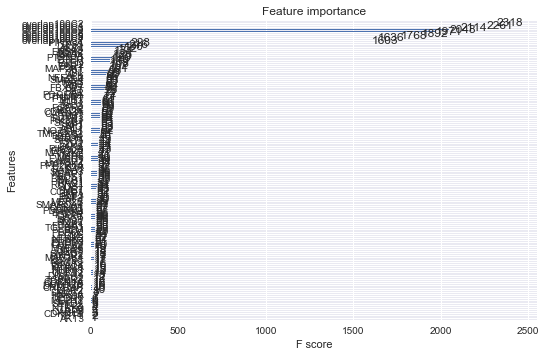

accuracy 0.658646616541 [3 4 4 5 7]


In [384]:
def mamourXgboost(df, features):
    print('\n##################\nXGBoost\n##################')
    param = {}
    # param['booster'] = 'gbtree'
    #param['objective'] = 'binary:logistic'
    # param["eval_metric"] = "error"
    # param['eta'] = 0.3
    # param['gamma'] = 0
    param['max_depth'] = 6
    param['n_estimators'] = 200
    param['learning_rate'] = 0.1
    # param['min_child_weight'] = 1
    # param['max_delta_step'] = 0
    # param['subsample'] = 1
    # param['colsample_bytree'] = 1
    # param['silent'] = 1
    # param['seed'] = 0
    # param['base_score'] = 0.4

    estimator = XGBClassifier()
    estimator.set_params(**param)
    x1, x2, y1, y2 = model_selection.train_test_split(df[features], df['Class'], test_size=0.2)
#     calibratedCV = CalibratedClassifierCV(estimator, method='sigmoid', cv=5)
#     calibratedCV.fit(x1, y1)
#     prediction = calibratedCV.predict(x2)
    
#     print(calibratedCV.best_estimator_.booster())
#     print(calibratedCV.calibrated_classifiers_)
#     for c in calibratedCV.calibrated_classifiers_:
#         print(c.feature_importances_)
#         plot_importance(c)
#         pyplot.show()
#     feat_imp = pd.Series(calibratedCV.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title = 'Feature imp')
    estimator.fit(x1, y1)
    prediction = estimator.predict(x2)
#     xgb.plot_importance(estimator, max_num_features = 50)
    imp = estimator.feature_importances_
    plot_importance(estimator)
    pyplot.show()

    print('accuracy %s %s' % (np.mean(prediction == y2), prediction[:5]))
    #result = calibratedCV.predict(test)
    # result = estimator.predict(test)
    #return result
    return imp

geneDummies = pd.get_dummies(train['Gene'])

features=['overlap100C'+str(c) for c in range(1, 10)]
features.extend(geneDummies.columns)

trainWithGenes = train.join(geneDummies)

xgboostImp = mamourXgboost(trainWithGenes, features)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


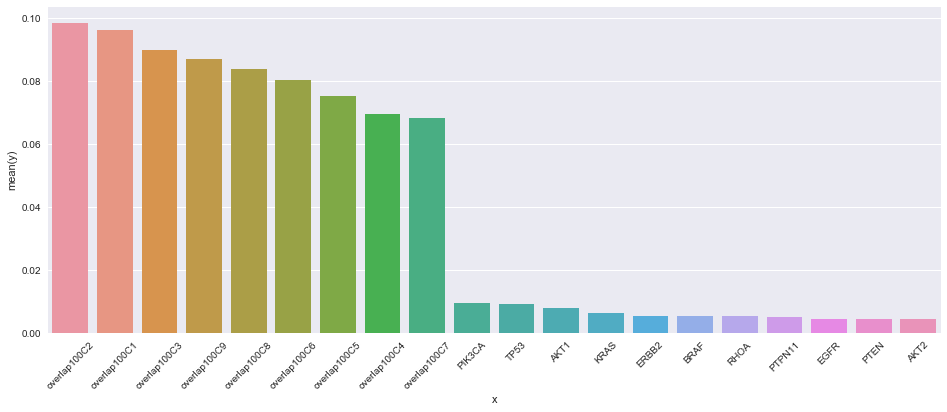

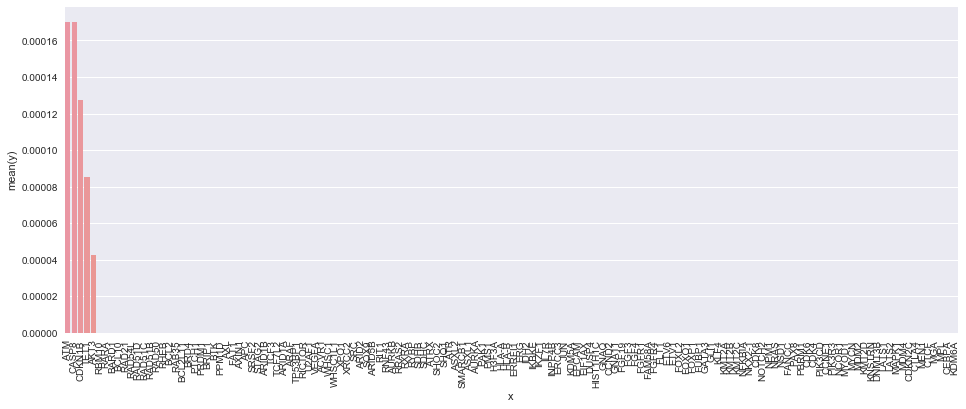

In [388]:
xgboostImp.shape
len(features)
xgboostFeatureImp = pd.DataFrame()
xgboostFeatureImp['x'] = features
xgboostFeatureImp['y'] = xgboostImp
xgboostFeatureImp = xgboostFeatureImp.sort(['y'], ascending = 0)
plt.figure(figsize = (16, 6))
plt.xticks(rotation=45)
sns.barplot(x = 'x', y ='y', data = xgboostFeatureImp[:20])
plt.show()
plt.figure(figsize = (16, 6))
plt.xticks(rotation=90)
sns.barplot(x = 'x', y ='y', data = xgboostFeatureImp[-140:])

In [237]:
def mamourLGBM(df, features):
    print('\n##################\mamourLGBM\n##################')
    parms = {'task': 'train',
             'boosting_type': 'gbdt',
             'objective': 'multiclass',
             'num_class': 9,
             'metric': {'multi_logloss'},
             'learning_rate': 0.05,
             'max_depth': 5,
             'num_iterations': 400,
             'num_leaves': 95,
             'min_data_in_leaf': 60,
             'lambda_l1': 1.0,
             'feature_fraction': 0.8,
             'bagging_fraction': 0.8,
             'bagging_freq': 5}
    
    classes =df['Class'] - 1
    x1, x2, y1, y2 = model_selection.train_test_split(df[features], classes, test_size=0.2)
    
    d_train = lgb.Dataset(x1, label=y1)
    d_val = lgb.Dataset(x2, label=y2, reference=d_train)

    rnds = 260
    mod = lgb.train(parms, train_set=d_train, num_boost_round=rnds,
                    valid_sets=[d_val], valid_names=['dval'], verbose_eval=20,
                    early_stopping_rounds=20)

    prediction = mod.predict(x2)
    prediction =  np.argmax(prediction, axis = 1)
    prediction = prediction
#     print('accuracy %s' % ( prediction[:5]))
    print('accuracy %s %s' % (np.mean(prediction == y2), prediction[:5]))
    #result = calibratedCV.predict(test)
    # result = estimator.predict(test)
    #return result
mamourLGBM(trainWithGenes, features)


##################\mamourLGBM
##################
Train until valid scores didn't improve in 20 rounds.
[20]	dval's multi_logloss: 1.58938
[40]	dval's multi_logloss: 1.3721
[60]	dval's multi_logloss: 1.27245
[80]	dval's multi_logloss: 1.21421
[100]	dval's multi_logloss: 1.17699
[120]	dval's multi_logloss: 1.15671
[140]	dval's multi_logloss: 1.14105
[160]	dval's multi_logloss: 1.1308
[180]	dval's multi_logloss: 1.11776
[200]	dval's multi_logloss: 1.11125
[220]	dval's multi_logloss: 1.10244
[240]	dval's multi_logloss: 1.095
[260]	dval's multi_logloss: 1.09135
accuracy 0.612030075188 [1 3 6 6 6]


In [343]:
numWordsToConsider = 200

allwords = set([])
for i in range(1,10):
    x = (mostPopularWords[i][:numWordsToConsider])
#     print(set(x))
    allwords = allwords | set(x) # set(list(allwords).extend(x))
    
len(allwords)
# print(allwords)

# len(train['fw'][1])

# wordDummies = pd.get_dummies(list(allwords))
# wordDummies

train2 = train

def topWordDummies(fw, topWords, wordsToConsider):
    r = [int(word in fw[:wordsToConsider]) for word in topWords]
    
    return r
    
# print(topWordDummies(train['fw'][5], allwords, 100))

# train2['fw'].apply(lambda x: topWordDummies(x,allwordlist,100)

print(len(allwordlist))
allwordlist = list(allwords)
for word in allwordlist:
    train2[word] = 0
# allwordlist = ['likely', 'number']
# train2[allwordlist] = train2['fw'].apply(lambda x: topWordDummies(x,allwordlist,100))

rr = train2['fw'].apply(lambda x: topWordDummies(x,allwordlist,numWordsToConsider))

print(rr.shape)
# print(rr)

train2[allwordlist] = rr[0]

train2.columns

features=['overlap' +str(numWordsToConsider) + 'C'+str(c) for c in range(1, 10)]
features.extend(allwordlist)
print(features)
# trainWithGenes = train.join(geneDummies)

mamourXgboost(train2, features)
mamourLGBM(train2, features)

678
(3321,)
['overlap200C1', 'overlap200C2', 'overlap200C3', 'overlap200C4', 'overlap200C5', 'overlap200C6', 'overlap200C7', 'overlap200C8', 'overlap200C9', 'et', 'assays', 'dimer', 'met', 'dcr', 'carry', 'rearrangements', 'probability', 'membrane', 'lines', 'antibodies', 'splicing', 'lymphoma', 'supplementary', 'vivo', 'v1736a', 'mutations', 'vus', 'unclassified', 'ezh2', 'bcl6', 'apoptosis', 'alk', 'tokyo', 'sarcoma', 'response', 'dnmt3b7', 'appendix', 'detected', 'lane', 'ovarian', 'smo', 'oncogenic', 'p11', 'surface', 'transfected', 'adult', 'methods', 'nrf2', 'complementation', 'm1775r', 'sourceturn', 'h3k27', 'myelodysplasia', 'nadph', 'sirna', 'tsc1', 'antibody', 'srf', 'pp2a', 'deptor', 'bap1', 's2215y', 'trans', 'keap1', 'bcorl1', 'activities', 'laboratories', 'tet2', 'used', 'status', 'type', 'pathway', 'p3', 'usage', 'new', 'ercc2', 'class', 'whereas', 'kd', 'r172k', 'present', 'human', 'aberrant', 'acc', 'rhoa', 'analyzed', 'jak2', 'notch1', 'core', 'genomic', 's492r', '17'

In [331]:
train2 = pd.DataFrame({'a':range(8)})
train2['e'] = 0
train2['f'] = 0
train2['g'] = 0
# print(train2.head(5))

def rrr(x,y):
    return [0.4, 0.6]

# print(train2.columns)

rr = train2.apply(lambda x: rrr(x["a"],3), axis=1)
print(rr.shape)
print(rr)
train2[['e','f']] = rr[0]


print(train2.head(5))

(8,)
0    [0.4, 0.6]
1    [0.4, 0.6]
2    [0.4, 0.6]
3    [0.4, 0.6]
4    [0.4, 0.6]
5    [0.4, 0.6]
6    [0.4, 0.6]
7    [0.4, 0.6]
dtype: object
   a    e    f  g
0  0  0.4  0.6  0
1  1  0.4  0.6  0
2  2  0.4  0.6  0
3  3  0.4  0.6  0
4  4  0.4  0.6  0


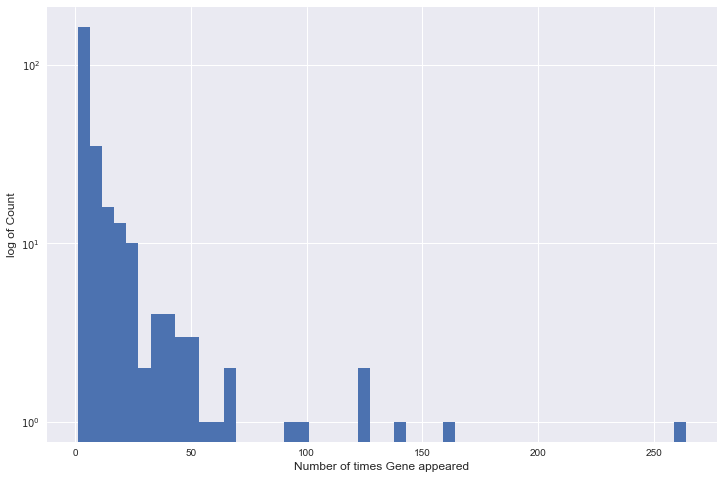

In [7]:

trainGenes = train.groupby('Gene')['Gene'].count()
# trainGenes.plot(kind='bar')
# plt.xlabel('Class Count', fontsize=5)
# plt.xticks(rotation=60)
# plt.show()


plt.figure(figsize=(12, 8))
plt.hist(trainGenes.values, bins=50, log=True)
plt.xlabel('Number of times Gene appeared', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()


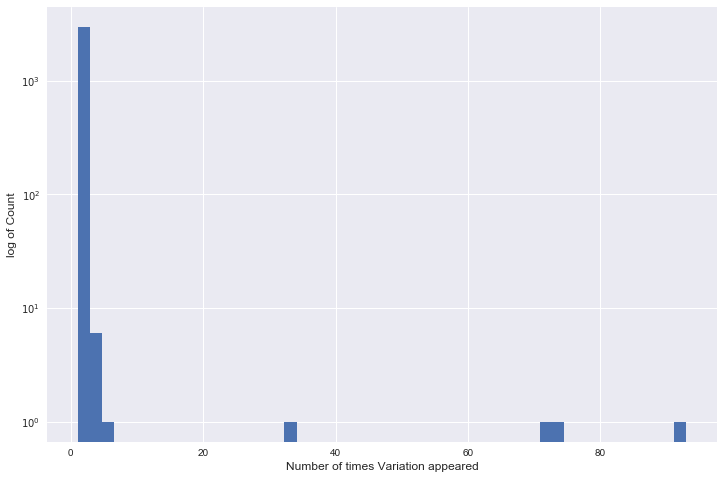

In [8]:
trainVariation = train.groupby('Variation')['Variation'].count()
plt.figure(figsize=(12, 8))
plt.hist(trainVariation.values, bins=50, log=True)
plt.xlabel('Number of times Variation appeared', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()

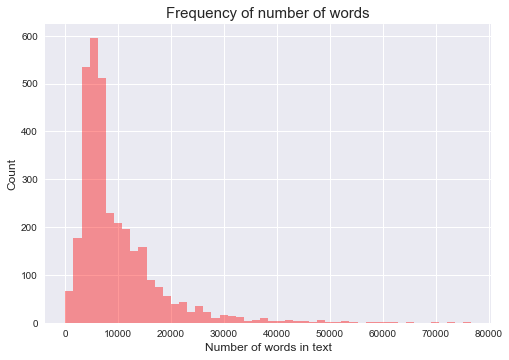

In [9]:
sns.distplot(train["nbWords"].values, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

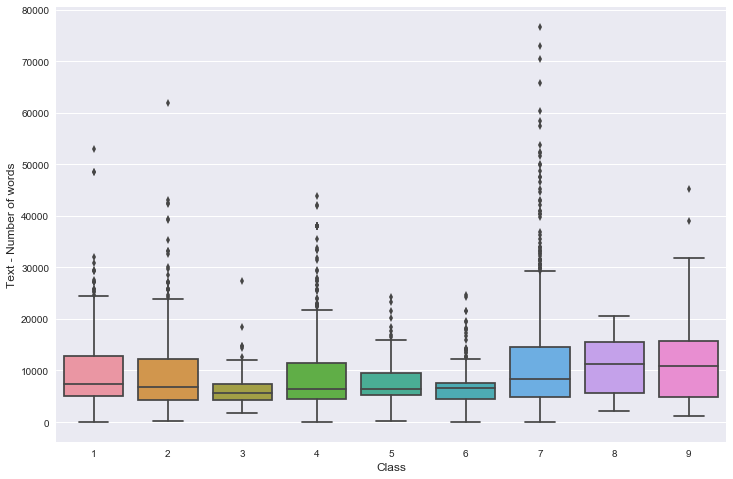

In [10]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Class', y='nbWords', data=train)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

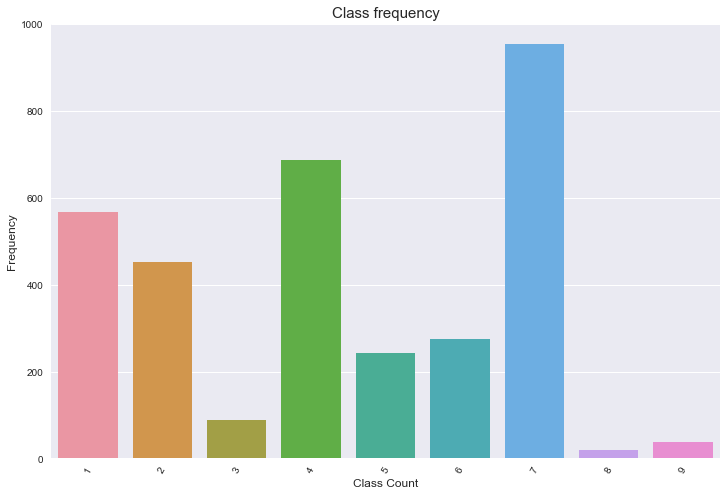

In [11]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation=60)
plt.title("Class frequency", fontsize=15)
plt.show()

In [12]:
# plt.figure(figsize=(12,8))
# plt.hist(train_genes, bins=50, log=True)
# plt.ylabel('log of count', fontsize=12)
# plt.xlabel('Genes distribution', fontsize=12)
# plt.xticks(rotation=60)
# plt.title("Gene frequency", fontsize=15)
# plt.show()

print('done')test_text', sep="\|\|", engine='python', header=None, names=["ID","Text"], skiprows=1)
pid = test['ID'].values

train = train.merge(trainingText, on='ID', how='left')
train["nbWords"] = train["Text"].apply(lambda x: len(str(x).split()) )


trainGenes = train.groupby('Gene')['Gene'].count()

SyntaxError: invalid syntax (<ipython-input-12-686289b75539>, line 9)